## PyTorch CAPTCHA Breaker

This cell contains the complete PyTorch implementation to break CAPTCHAs, generated using Gemini AI from the original python code of lab 2. It performs the full pipeline: data loading, preprocessing, model definition, training, and evaluation. It runs fine as long as
- `captcha-images.tar.xz` is in the same directory.
- `lab_2_helpers.py` is in the same directory.


Using device for PyTorch: cpu

--- Starting Data Loading and Preprocessing ---
Directory ./captcha-images already exists and contains images, skipping extraction.
Train-validation CAPTCHAs: 908, Test CAPTCHAs: 228
Extracting and saving individual characters to ./char-images-31528476...
Preparing features and labels for character classification...
Data prepared for PyTorch: n_classes=32, X_train shape=(2676, 20, 20, 1), X_vali shape=(892, 20, 20, 1)

PyTorch Model Summary:
CaptchaPyTorchModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=32, bias=True)

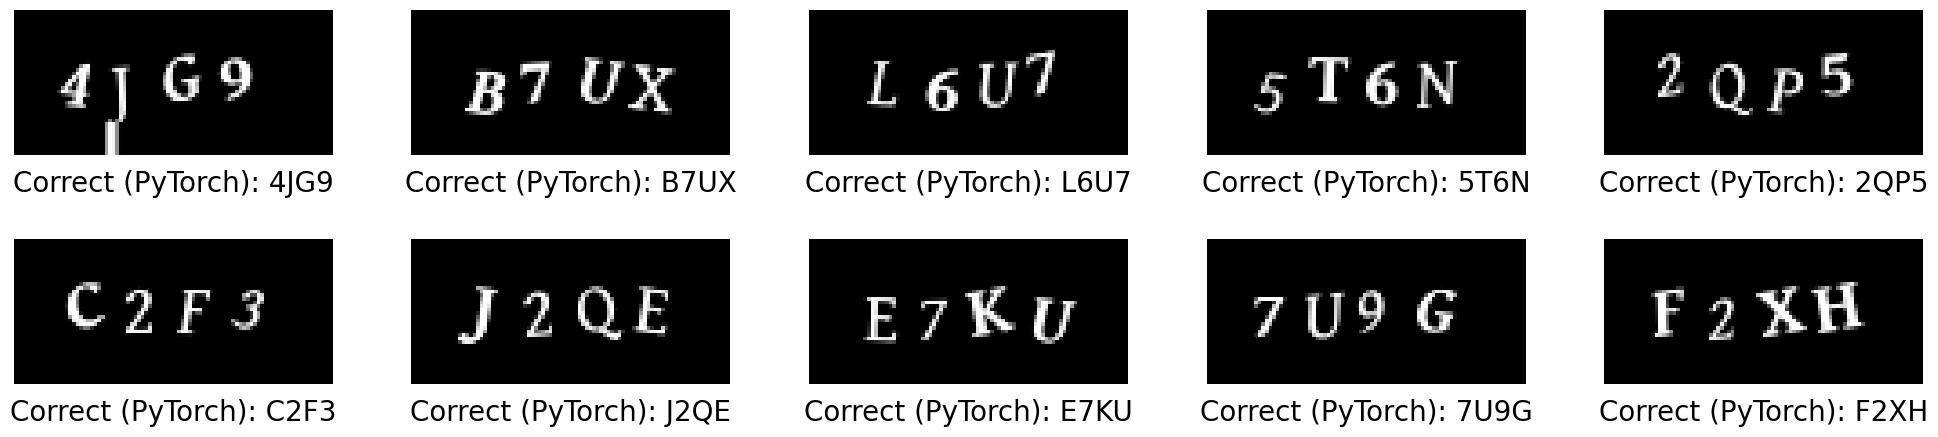

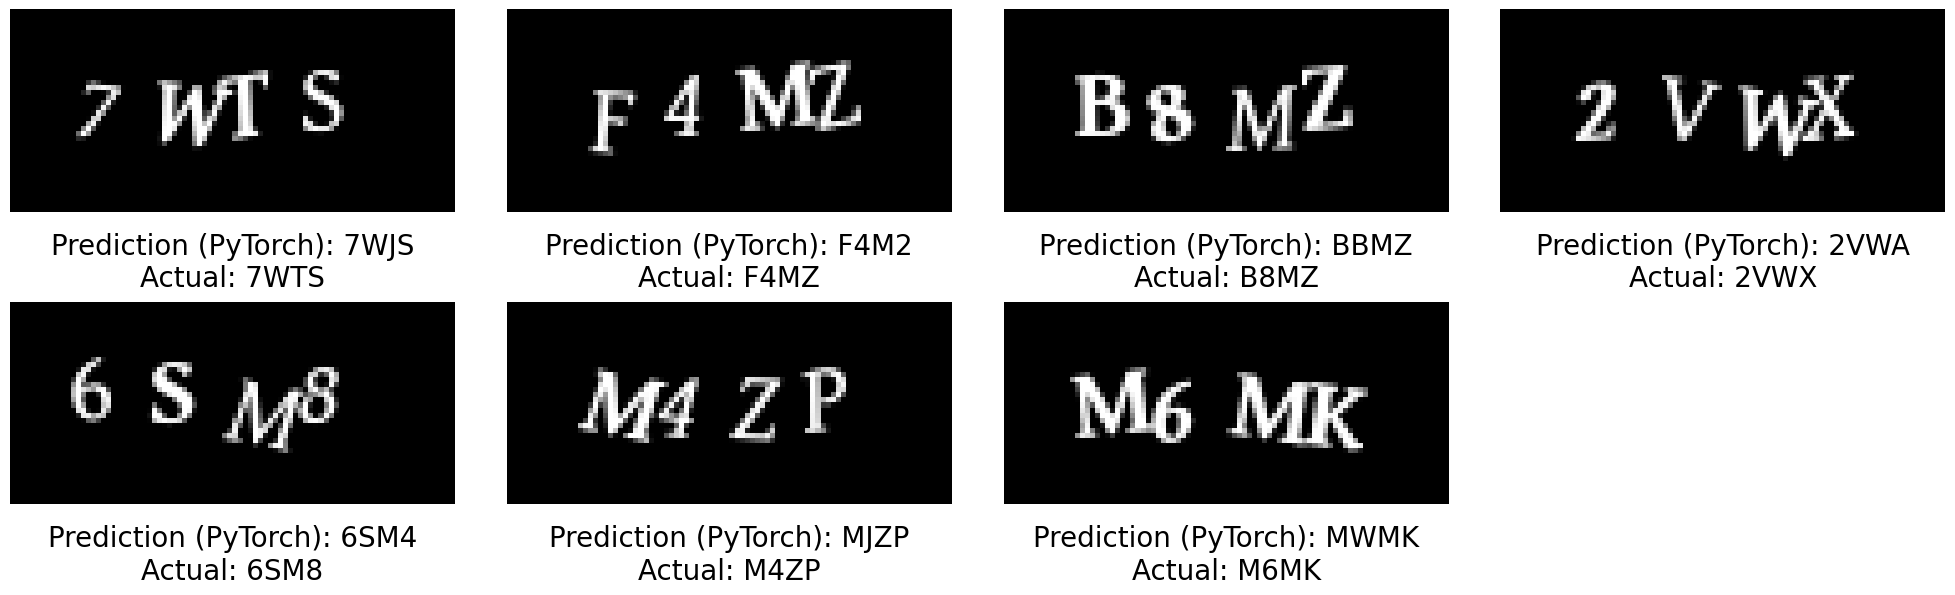

In [3]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

# --- Import helper functions from lab_2_helpers.py ---
# Assuming lab_2_helpers.py is in the same directory
from lab_2_helpers import unzip, group_every, print_images, resize_to_fit

# --- Configuration & Global Variables ---
CAPTCHA_IMAGE_FOLDER = "./captcha-images"
TVT_SPLIT_SEED = 31528476
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"
LABELS_PATH = "./labels.pkl"
BATCH_SIZE = 32
N_EPOCHS = 10
N_DISPLAY_SAMPLES = 10

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device for PyTorch: {device}")

# --- Custom Helper Functions (if not already in lab_2_helpers.py) ---
# These are often project-specific or for convenience.
# Redefining them here to ensure self-containment.

def extract_captcha_text(image_path):
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

def load_transform_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    return image_padded

def extract_chars(image):
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))
    if len(char_regions)!=4:
        return None
    char_regions.sort(key=lambda x: x[0])
    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)
        char_counts[char] = char_count+1

def make_feature(image):
    image_resized = resize_to_fit(image, 20, 20)
    feature = image_resized[..., None]
    return feature

def make_feature_label(image_path):
    feature = make_feature(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

# --- Data Loading and Preprocessing ---
print("\n--- Starting Data Loading and Preprocessing ---")

# Ensure captcha-images are extracted into the correct folder
# Check if the folder exists AND contains images, otherwise extract/re-extract.
if not os.path.exists(CAPTCHA_IMAGE_FOLDER) or not list(paths.list_images(CAPTCHA_IMAGE_FOLDER)):
    print(f"Creating directory {CAPTCHA_IMAGE_FOLDER} and extracting captcha images...")
    os.makedirs(CAPTCHA_IMAGE_FOLDER, exist_ok=True) # Ensure the directory exists
    os.system(f'tar -xJf captcha-images.tar.xz -C {CAPTCHA_IMAGE_FOLDER}') # Extract into the created directory
else:
    print(f"Directory {CAPTCHA_IMAGE_FOLDER} already exists and contains images, skipping extraction.")

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]

# Split data into train-validation and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)
print(f"Train-validation CAPTCHAs: {len(captcha_texts_tv)}, Test CAPTCHAs: {len(captcha_texts_test)}")

# Extract and save individual characters
FORCE_EXTRACT_CHAR = True # Set to True to re-extract every time, False to use existing
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    print(f"Extracting and saving individual characters to {CHAR_IMAGE_FOLDER}...")
    if os.path.exists(CHAR_IMAGE_FOLDER):
        import shutil
        shutil.rmtree(CHAR_IMAGE_FOLDER)
    char_counts = {}
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None:
            continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)
else:
    print(f"Character images already exist at {CHAR_IMAGE_FOLDER}, skipping extraction.")

# Prepare features and labels for model training
print("Preparing features and labels for character classification...")
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))
features_tv = np.array(features_tv, dtype="float") / 255

lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
n_classes = len(lb.classes_)

# Further split into training and validation sets for character classification
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)

# Save LabelBinarizer for inverse transformation later
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

print(f"Data prepared for PyTorch: n_classes={n_classes}, X_train shape={X_train.shape}, X_vali shape={X_vali.shape}")

# --- PyTorch Model Definition ---
class CaptchaPyTorchModel(nn.Module):
    def __init__(self, num_classes):
        super(CaptchaPyTorchModel, self).__init__()
        # First convolution block: Input (N, 1, 20, 20) -> Conv2d -> MaxPool2d (N, 20, 10, 10)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2) # padding=2 for 'same' with kernel_size=5
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution block: Input (N, 20, 10, 10) -> Conv2d -> MaxPool2d (N, 50, 5, 5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Flattened size before FC: 50 channels * 5 height * 5 width = 1250
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        # PyTorch Conv2d expects input in (N, C, H, W) format.
        # Original TensorFlow model processed images as (N, H, W, C=1).
        # Reorder dimensions: (batch_size, height, width, channels) -> (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2) # N, H, W, C -> N, C, H, W

        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1) # Flatten all dimensions except the batch dimension

        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the PyTorch model
pytorch_model = CaptchaPyTorchModel(n_classes).to(device)
print("\nPyTorch Model Summary:")
print(pytorch_model)

# --- Prepare DataLoaders for PyTorch Training ---
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(np.argmax(y_train, axis=1)).long() # Convert one-hot to class indices

X_vali_tensor = torch.from_numpy(X_vali).float()
y_vali_tensor = torch.from_numpy(np.argmax(y_vali, axis=1)).long() # Convert one-hot to class indices

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
vali_dataset = TensorDataset(X_vali_tensor, y_vali_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("PyTorch DataLoaders created.")

# --- PyTorch Training Loop ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

print("\nStarting PyTorch Model Training...")
for epoch in range(N_EPOCHS):
    pytorch_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pytorch_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    pytorch_model.eval() # Set model to evaluation mode
    correct_vali = 0
    total_vali = 0
    vali_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations during validation
        for inputs, labels in vali_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pytorch_model(inputs)
            loss = loss_fn(outputs, labels)
            vali_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_vali += labels.size(0)
            correct_vali += (predicted == labels).sum().item()

    vali_accuracy = 100 * correct_vali / total_vali

    print(f"Epoch {epoch+1}/{N_EPOCHS}, "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {vali_loss/len(vali_loader):.4f}, "
          f"Val Acc: {vali_accuracy:.2f}%")

print("PyTorch Model Training Finished.")

# --- PyTorch Model Evaluation on Test Data ---
print("\n--- Evaluating PyTorch Model on Test Data ---")
pytorch_model.eval() # Set model to evaluation mode

# Prepare features for individual characters from the test CAPTCHA images
print("Preparing features for test set characters...")
test_char_features = []
test_char_actual_labels = []
extract_failed_indices_for_test = [] # Track CAPTCHAs where extraction fails

for i, (captcha_image, captcha_text) in enumerate(zip(captcha_images_test, captcha_texts_test)):
    char_images = extract_chars(captcha_image)
    if char_images is None:
        extract_failed_indices_for_test.append(i)
        continue

    for j, char_image in enumerate(char_images):
        feature = make_feature(char_image)
        test_char_features.append(feature)
        test_char_actual_labels.append(captcha_text[j])

# Convert to numpy array and normalize
test_char_features_np = np.array(test_char_features, dtype="float") / 255
test_char_features_tensor = torch.from_numpy(test_char_features_np).float().to(device)

# Perform predictions
all_preds_test_pytorch_indices = []
with torch.no_grad():
    outputs = pytorch_model(test_char_features_tensor)
    _, predicted_indices = torch.max(outputs.data, 1)
    all_preds_test_pytorch_indices.extend(predicted_indices.cpu().numpy())

# Convert predicted indices back to character labels
preds_test_pytorch_one_hot = F.one_hot(torch.tensor(all_preds_test_pytorch_indices).long(), num_classes=n_classes).cpu().numpy()
preds_test_chars_pytorch = lb.inverse_transform(preds_test_pytorch_one_hot)

# Reconstruct full CAPTCHA text predictions, handling failed extractions
preds_test_grouped_pytorch = []
current_char_output_idx = 0
for i in range(len(captcha_images_test)):
    if i in extract_failed_indices_for_test:
        preds_test_grouped_pytorch.append("-")
    else:
        # Assuming 4 characters per CAPTCHA
        predicted_chars_for_captcha = preds_test_chars_pytorch[current_char_output_idx : current_char_output_idx + 4]
        preds_test_grouped_pytorch.append("".join(predicted_chars_for_captcha))
        current_char_output_idx += 4

# Calculate and print accuracy
n_correct_pytorch = 0
n_test_pytorch_evaluated = 0
for i, (pred_text, actual_text) in enumerate(zip(preds_test_grouped_pytorch, captcha_texts_test)):
    if pred_text == "-": # Skip CAPTCHAs where character extraction failed
        continue
    n_test_pytorch_evaluated += 1
    if pred_text == actual_text:
        n_correct_pytorch += 1

pytorch_accuracy = n_correct_pytorch / n_test_pytorch_evaluated if n_test_pytorch_evaluated > 0 else 0.0
print(f"\nPyTorch Model Test Accuracy: {pytorch_accuracy:.4f}")

# --- Comparison with TensorFlow results (hardcoded from previous run for self-containment) ---
tf_n_correct = 218
tf_n_test = 228
tf_accuracy = tf_n_correct / tf_n_test

print("\n--- Comparison of Predictions (PyTorch vs. TensorFlow) ---")
print(f"TensorFlow accuracy: {tf_accuracy:.4f} (from original notebook's run)")
print(f"PyTorch accuracy: {pytorch_accuracy:.4f}")

# Display images for visual inspection (correct and incorrect predictions)
correct_pytorch_display_indices = []
incorrect_pytorch_display_indices = []
for i, (pred_text, actual_text) in enumerate(zip(preds_test_grouped_pytorch, captcha_texts_test)):
    if pred_text == actual_text and len(correct_pytorch_display_indices) < N_DISPLAY_SAMPLES:
        correct_pytorch_display_indices.append(i)
    elif pred_text != actual_text and pred_text != "-" and len(incorrect_pytorch_display_indices) < N_DISPLAY_SAMPLES:
        incorrect_pytorch_display_indices.append(i)

# Only call print_images if there are images to display
if correct_pytorch_display_indices:
    print_images(
        [captcha_images_test[i] for i in correct_pytorch_display_indices],
        texts=[f"Correct (PyTorch): {captcha_texts_test[i]}" for i in correct_pytorch_display_indices],
        n_rows=2,
        fig_size=(20, 5)
    )
else:
    print("\nNo correct PyTorch predictions to display.")

if incorrect_pytorch_display_indices:
    print_images(
        [captcha_images_test[i] for i in incorrect_pytorch_display_indices],
        texts=[
            f"Prediction (PyTorch): {preds_test_grouped_pytorch[i]}\nActual: {captcha_texts_test[i]}"
            for i in incorrect_pytorch_display_indices
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )
else:
    print("\nNo incorrect PyTorch predictions to display.")
